# `LSTM`

LSTM的结构如下图所示

<img src="./figs/lstm1.png" width="400px" />

PyTorch的官方文档中对`torch.nn.LSTM`的解释如下：

Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence. For **each** element in the input sequence, **each layer** computes the following function:

$$
\begin{split}
i_t&=\sigma(W_{ii}x_t+b_{ii}+W_{hi}h_{t-1}+b_{hi})\\
f_t&=\sigma(W_{if}x_t+b_{if}+W_{hf}h_{t-1}+b_{hf})\\
g_t&=\tanh(W_{ig}x_t+b_{ig}+W_{hg}h_{t-1}+b_{hg})\\
o_t&=\sigma(W_{io}x_t+b_{io}+W_{ho}h_{t-1}+b_{ho})\\
c_t&=f_t\odot c_{t-1}+i_t\odot g_t\\
h_t&=o_t\odot \tanh(c_t)
\end{split}
$$
where $h_t$ is the hidden state at time $t$, $c_t$ is the cell state at time $t$, $x_t$ is the input at time $t$, $h_{t-1}$ is the hidden state of the layer at time $t-1$ or the initial hidden state at time 0, and $i_t$, $f_t$, $g_t$ $o_t$ are the input, forget, cell, and output gates, respectively. $\sigma$ is the sigmoid function, and $\odot$ is the Hadamard product.

上面是文档中对于单层LSTM的解释, 如果LSTM为多层, 则有以下附加说明

In a **multilayer** LSTM, the input $x^{(l)}_t$ of the $l$-th layer ($l\geq 2$) is the hidden state $h^{(l-1)}_t$ of the previous layer multiplied by dropout $\delta^{(l-1)}_t$, where each $\delta^{(l-1)}_t$ is a Bernoulli random variable which is 0 with probability `dropout`.

另外一个会改变LSTM操作的参数是`proj_size`, 官方解释如下:

If `proj_size`>0 is specified, LSTM with projections will be used. This changes the LSTM cell in the following way. First, the dimension of $h_t$ will be changed from `hidden_size` to `proj_size` (dimension of $W_{hi}$ will be changed accordingly). Second, the output hidden state of each layer will be multiplied by a learnable projection matrix: $h_t=W_{hr}h_t$. Note that as a consequence of this, the output of LSTM network will be of different shape as well.

`torch.nn.LSTM`各参数含义如下：

- `input_size` – The number of expected features in the input $x$.
- `hidden_size` – The number of features in the hidden state $h$.
- `num_layers` – Number of recurrent layers. E.g., setting `num_layers=2` would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1.
- `bias` – If `False`, then the layer does not use bias weights $b_ih$ and $b_hh$. Default: `True`.
- `batch_first` – If True, then the input and output tensors are provided as $(batch, seq, feature)$ instead of $(seq, batch, feature)$. Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: `False`.
- `dropout` – If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0.
- `bidirectional` – If True, becomes a bidirectional LSTM. Default: `False`.
- `proj_size` – If > 0, will use LSTM with projections of corresponding size. Default: 0.

模型输入数据含义如下:

>Inputs: `input`, (`h_0`, `c_0`)

- `input`: tensor of shape $(L,H_{in})$ for unbatched input, $(L, N, H_{in})$ when `batch_first=False` or $(N,L,H_{in})$ when `batch_first=True` containing the features of the input sequence.
- `h_0`: tensor of shape $(D\times num\_layers, H_{out})$ for unbatched input or $(D\times num\_layers, N, H_{out})$ containing the initial hidden state for each element in the input sequence. Defaults to zeros if (`c_0`, `h_0`) is not provided.
- `c_0`: tensor of shape $(D\times num\_layers,H_{cell})$ for unbatched input or $(D\times num\_layers,N,H_{cell})$ containing the initial cell state for each element in the input sequence. Defaults to zeros if (`c_0`, `h_0`) is not provided.

where 

$$
\begin{split}
N&=\text{batch size}\\
L&=\text{sequence length}\\
D&=\text{2 if bidirectional=True otherwise 1}\\
H_{in}&=\text{input\_size}\\
H_{cell}&=\text{hidden\_size}\\
H_{out}&=\text{proj\_size if proj\_size>0 otherwise hidden\_size}
\end{split}
$$

模型输出数据含义如下:

>Output: `output`, (`h_n`, `c_n`)

- `output`: tensor of shape $(L, D\times H_{out})$ for unbatched input, $(L,N,D\times H_{out})$ when `batch_first=False` or $(N,L,D\times H_{out})$ when `batch_first=True` containing the output features (*h_t*) from the **last layer** of the LSTM, for each $t$ (就是最后一层的隐含层特征). 
- `h_n`: tensor of shape $(D\times num\_layers, H_{out})$ for unbatched input or $(D\times num\_layers,N, H_{out})$ containing the final hidden state for each element in the sequence. When `bidirectional = True`, `h_n` will contain a concatenation of the final forward and reverse hidden states, respectively.
- `c_n`: tensor of shape $(D\times num\_layers, H_{cell})$ for unbatched input or $(D\times num\_layers, N, H_{cell})$ containing the final cell state for each element in the sequence. When `bidirectional = True`, `c_n` will contain a concatenation of the final forward and reverse hidden states, respectively.

# `LSTMCell`

`LSTMCell` is a LSTM cell.

>`torch.nn.LSTMCell`(`input_size`,`hidden_size`, `bias=True`, `device=None`, `dtype=None`)
$$
\begin{split}
i&=\sigma(W_{ii}x+b_{ii}+W_{hi}h+b_{hi})\\
f&=\sigma(W_{if}x+b_{if}+W_{hf}h+b_{hf})\\
g&=\tanh(W_{ig}x+b_{ig}+W_{hg}h+b_{hg})\\
o&=\sigma(W_{io}x+b_{io}+W_{ho}h+b_{ho})\\
c'&=f\odot c+i\odot g\\
h'&=o\odot \tanh(c')
\end{split}
$$

各参数含义如下:

- `input_size(int)`-The number of expected features in the input $x$.
- `hidden_size(int)`-The number of features in the hidden state $h$.
- `bias(bool)`-If `Flase`, then the layer does not use bias weight $b_{ih}$ and $b_{hh}$. Default: `True`.

输入数据含义如下:

>Inputs:`input`, `(h_0,c_0)`

- `input`: tensor of shape ($batch,input\_size$) or ($input\_size$): tensor containing input features.
- `h_0`: tensor of shape ($batch,hidden\_size$) or ($hidden\_size$): tensor containing the initial hidden state.
- `c_0`: tensor of shape ($batch, hidden\_size$) or ($hidden\_size$): tensor containing the initial cell state.

If (`h_0`, `c_0`) is not provided, both `h_0` and `c_0` default to zero.

输出数据含义如下:

>Outputs:(`h_1`, `c_1`)

- `h_1`: tensor of shape ($batch,hidden\_size$) or ($hidden\_size$): tensor containing the next hidden state.
- `c_1`: tensor of shape ($batch,hidden\_size$) or ($hidden\_size$): tensor containing the next cell state.

# Kaggle金价预测数据集

>This DataSet includes the real time gold prices(in USD) from 2012 to 2022 [1].

数据集中各字段含义如下:

- **Date**: Date on which Price is Noted
- **Close**: Close Price of the Gold in USD
- **Volume**: Sum of buy's and sell's of Gold Commodity
- **open**: open price of a Gold on that particular day
- **High**: High price of Gold on that particular day
- **Low**: Low price of Gold on that particular day

# `LSTM`预测金价

加载数据集

In [507]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import os
import matplotlib.pyplot as plt 

DIR = '~/prj/tech_notes/learning_alg/src/data/'
fname = 'kaggle_gold_price_prediction.csv'

dataset = pd.read_csv(os.path.join(DIR, fname))
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547 entries, 0 to 2546
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2547 non-null   object 
 1   Close/Last  2547 non-null   float64
 2   Volume      2508 non-null   float64
 3   Open        2547 non-null   float64
 4   High        2547 non-null   float64
 5   Low         2547 non-null   float64
dtypes: float64(5), object(1)
memory usage: 119.5+ KB


生成训练集和测试集

In [508]:
# 根据时间倒序排列.
dataset = dataset.sort_index(axis = 0, ascending = False)
dataset

,Date,Close/Last,Volume,Open,High,Low
2546,10/31/2012,1719.1,110928.0,1710.3,1726.6,1709.8
2545,11/01/2012,1715.5,105904.0,1720.4,1727.5,1715.1
2544,11/02/2012,1675.2,205777.0,1715.6,1717.2,1674.8
2543,11/05/2012,1683.2,109647.0,1676.7,1686.2,1672.5
2542,11/06/2012,1715.0,163585.0,1685.4,1720.9,1683.5
...,...,...,...,...,...,...
4,10/24/2022,1654.1,167448.0,1662.9,1675.5,1648.0
3,10/25/2022,1658.0,178706.0,1654.5,1666.8,1641.2
2,10/26/2022,1669.2,183453.0,1657.7,1679.4,1653.8
1,10/27/2022,1668.8,180599.0,1668.8,1674.8,1658.5


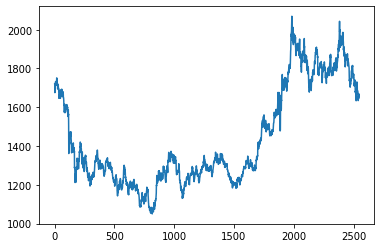

In [509]:
plt.plot([i for i in range(len(dataset))], dataset['Close/Last'])
plt.show()

数据清洗. `Volume`属性中含有空值, 本次实验用均值进行填充.

In [510]:
mean = dataset['Volume'].mean()
dataset['Volume'].fillna(mean, inplace = True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2547 entries, 2546 to 0
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2547 non-null   object 
 1   Close/Last  2547 non-null   float64
 2   Volume      2547 non-null   float64
 3   Open        2547 non-null   float64
 4   High        2547 non-null   float64
 5   Low         2547 non-null   float64
dtypes: float64(5), object(1)
memory usage: 139.3+ KB


目标为预测收市价. 因此，将`Close/Last`作为标签, 并将除`Date`外的字段作为特征输入模型. 本次实验将前2500天作为训练集, 后47天作为测试集.

In [511]:
train_set = dataset[:2500]
train_set

,Date,Close/Last,Volume,Open,High,Low
2546,10/31/2012,1719.1,110928.0,1710.3,1726.6,1709.8
2545,11/01/2012,1715.5,105904.0,1720.4,1727.5,1715.1
2544,11/02/2012,1675.2,205777.0,1715.6,1717.2,1674.8
2543,11/05/2012,1683.2,109647.0,1676.7,1686.2,1672.5
2542,11/06/2012,1715.0,163585.0,1685.4,1720.9,1683.5
...,...,...,...,...,...,...
51,08/17/2022,1776.7,134521.0,1790.8,1796.6,1773.9
50,08/18/2022,1771.2,119686.0,1777.1,1786.3,1768.8
49,08/19/2022,1762.9,133714.0,1773.1,1773.3,1759.1
48,08/22/2022,1748.4,137883.0,1760.6,1762.1,1740.2


In [512]:
test_set = dataset[2500:]
test_set

,Date,Close/Last,Volume,Open,High,Low
46,08/24/2022,1761.5,111405.00000,1761.3,1769.5,1754.8
45,08/25/2022,1771.4,114539.00000,1764.4,1778.8,1763.0
44,08/26/2022,1749.8,169654.00000,1771.8,1772.3,1746.2
43,08/29/2022,1749.7,151838.00000,1748.4,1757.9,1731.4
42,08/30/2022,1736.3,126018.00000,1749.8,1752.8,1732.9
41,08/31/2022,1726.2,169549.00000,1735.5,1738.0,1720.6
40,09/01/2022,1709.3,192532.00000,1723.0,1723.0,1699.1
39,09/02/2022,1722.6,171140.00000,1707.8,1729.5,1705.9
38,09/06/2022,1712.9,202021.00000,1724.2,1737.4,1710.6
37,09/07/2022,1727.8,169690.00000,1712.9,1731.2,1701.7


定义数据迭代器.

In [513]:
import random

def data_iter(data, time_step, batch_size):
    '''
    output shape (time_step, batch_size, feature_size)
    '''
    end_index = len(data) - time_step - 1
    sample_indices = [list(range(end_index)) for i in range(batch_size)]
    for i in range(batch_size):
        random.shuffle(sample_indices[i])
    for i in range(end_index):
        features, labels = [], []
        for j in range(time_step):
            features.append([data.iloc[sample_indices[k][i] + j].to_numpy() for k in range(batch_size)])
            labels.append([data['Close/Last'].iloc[sample_indices[k][i] + j + 1] for k in range(batch_size)])
        features, labels = np.array(features), np.array(labels)
        yield (torch.tensor(features, dtype = torch.float32), torch.tensor(labels, dtype = torch.float32))

定义LSTM模型

In [514]:
from torch import nn

class LSTMPred(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size, bidirection = False):
        super(LSTMPred, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.D = 1 if bidirection is False else 2
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, 1)
        self.state = None
    
    def reset_state(self):
        self.state = (
            torch.zeros(self.D * self.num_layers, self.batch_size, self.hidden_size),
            torch.zeros(self.D * self.num_layers, self.batch_size, self.hidden_size)
        )
    
    def forward(self, X):
        out, self.state = self.lstm(X, self.state)
        # out的形状为(time_step, batch_size, input_size)
        out = self.linear(out.view(-1, out.shape[-1]))
        return out, self.state

模型训练函数

In [515]:
def train(model, train_set, num_epochs, lr, time_step):
    loss = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    batch_size = model.batch_size
    for i in range(num_epochs):
        err = []
        for X, Y in data_iter(train_set, time_step, batch_size):
            model.reset_state()
            pred, model.state = model(X)
            # `pred`的形状为(batch_size * time_step, 1), 而`Y`的形状
            # 为(time_step, batch_size)
            Y = Y.reshape(-1, 1)
            l = loss(pred, Y)
            err.append(l.item())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        err = np.mean(err)
        print('The loss of %d-th epoch is: %.2f' % (i, err))

定义预测函数

In [516]:
def predict(model, test_set, batch_size):
    loss = nn.MSELoss()
    with torch.no_grad():
        time_step = len(test_set) // batch_size
        features, labels = [], []
        for j in range(time_step):
            features.append([test_set.iloc[k * time_step + j].to_numpy() for k in range(batch_size)])
            labels.append([test_set['Close/Last'][k * time_step + j] for k in range(batch_size)])
        features, labels = np.array(features), np.array(labels)
        features = torch.tensor(features, dtype = torch.float32)
        labels = torch.tensor(labels, dtype = torch.float32)
        model.reset_state()
        pred, model.state = model(features)
        labels = labels.reshape(-1, 1)
        l = loss(pred, labels)
        print('loss is %.2f' % (l))
        pred = pred.reshape(time_step, batch_size)
        labels = labels.reshape(time_step, batch_size)
        fig, axies = plt.subplots(nrows = batch_size, ncols= 1)
        for i in range(batch_size):
            axies[i].plot([j for j in range(time_step)], pred[:, i], c = 'b')
            axies[i].plot([j for j in range(time_step)], labels[:, i], c = 'r')
        plt.show()

测试程序

begin train
The loss of 0-th epoch is: 74293.52
The loss of 1-th epoch is: 68103.23
The loss of 2-th epoch is: 68102.65
The loss of 3-th epoch is: 67579.02
The loss of 4-th epoch is: 67777.58
The loss of 5-th epoch is: 68142.27
The loss of 6-th epoch is: 67869.62
The loss of 7-th epoch is: 67845.84
The loss of 8-th epoch is: 67641.21
The loss of 9-th epoch is: 67624.83
begin predict
loss is 49338.08


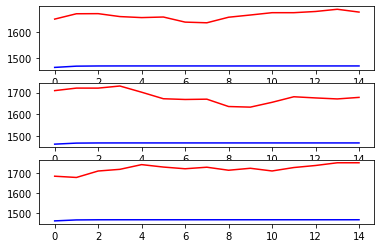

In [517]:
dataset.drop('Date', axis = 1, inplace = True)
train_set = dataset[:2500]
test_set = dataset[2500:]

# 超参
input_size = 5 # 去掉`Date`后, 还有5个特征.
hidden_size = 30
num_layers = 1
batch_size = 3
num_epochs = 10
lr = 0.01
time_step = 10

model = LSTMPred(input_size, hidden_size, num_layers, batch_size)
print('begin train')
train(model, train_set, num_epochs, lr, time_step)
print('begin predict')
predict(model, test_set, batch_size)

# References

[1] https://www.kaggle.com/datasets/saikumartamminana/gold-price-prediction